In [4]:
import csv
import numpy as np
import pandas as pd

# Loading Videos

In [6]:
# Load the dataset
DATASET_PATH = "/kaggle/input/all-keypoints/all_keypoints.csv"
data = pd.read_csv(DATASET_PATH)

# Display the first few rows
print(data.head())

   LEFT_SHOULDER_x  LEFT_SHOULDER_y  LEFT_SHOULDER_z  RIGHT_SHOULDER_x  \
0         0.451748         0.436819        -0.042916          0.262222   
1         0.450829         0.435406        -0.070738          0.262338   
2         0.450122         0.437296        -0.099768          0.263905   
3         0.449137         0.444341        -0.116625          0.265899   
4         0.449090         0.454269        -0.146686          0.268507   

   RIGHT_SHOULDER_y  RIGHT_SHOULDER_z  LEFT_HIP_x  LEFT_HIP_y  LEFT_HIP_z  \
0          0.435458         -0.050641    0.412529    0.570537   -0.005028   
1          0.434991         -0.083658    0.411987    0.570538   -0.005053   
2          0.436276         -0.114110    0.410663    0.571639   -0.005079   
3          0.441857         -0.121220    0.409786    0.572602   -0.005122   
4          0.448687         -0.145158    0.409518    0.574688   -0.004759   

   RIGHT_HIP_x  ...  LEFT_ANKLE_x  LEFT_ANKLE_y  LEFT_ANKLE_z  RIGHT_ANKLE_x  \
0     0.3077

In [8]:
print(data.columns)

Index(['LEFT_SHOULDER_x', 'LEFT_SHOULDER_y', 'LEFT_SHOULDER_z',
       'RIGHT_SHOULDER_x', 'RIGHT_SHOULDER_y', 'RIGHT_SHOULDER_z',
       'LEFT_HIP_x', 'LEFT_HIP_y', 'LEFT_HIP_z', 'RIGHT_HIP_x', 'RIGHT_HIP_y',
       'RIGHT_HIP_z', 'LEFT_KNEE_x', 'LEFT_KNEE_y', 'LEFT_KNEE_z',
       'RIGHT_KNEE_x', 'RIGHT_KNEE_y', 'RIGHT_KNEE_z', 'LEFT_ANKLE_x',
       'LEFT_ANKLE_y', 'LEFT_ANKLE_z', 'RIGHT_ANKLE_x', 'RIGHT_ANKLE_y',
       'RIGHT_ANKLE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'label'],
      dtype='object')


# Extracting Features

In [9]:
# List of keypoint names
keypoint_names = [
    'LEFT_SHOULDER', 'RIGHT_SHOULDER',
    'LEFT_HIP', 'RIGHT_HIP',
    'LEFT_KNEE', 'RIGHT_KNEE',
    'LEFT_ANKLE', 'RIGHT_ANKLE',
    'NOSE'
]

def compute_angle(a, b, c):
    """
    Compute the angle between three points.
    a, b, c are numpy arrays of shape (2,) or (3,) representing (x, y) or (x, y, z) coordinates.
    """
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)  # Convert to degrees

def compute_hip_center(left_hip, right_hip):
    """
    Compute the midpoint between the left and right hips.
    left_hip and right_hip are numpy arrays of shape (2,) or (3,) representing (x, y) or (x, y, z) coordinates.
    """
    return (left_hip + right_hip) / 2

def extract_keypoints(frame, keypoint_names):
    """
    Extract x, y, z coordinates for all keypoints in the list.
    frame: A numpy array representing a single frame of keypoints.
    keypoint_names: List of keypoint names (e.g., 'LEFT_SHOULDER').
    """
    keypoints = {}
    for name in keypoint_names:
        x = frame[data.columns.get_loc(f'{name}_x')]
        y = frame[data.columns.get_loc(f'{name}_y')]
        z = frame[data.columns.get_loc(f'{name}_z')]
        keypoints[name] = np.array([x, y, z])
    return keypoints

def compute_squat_angles(keypoints):
    """
    Compute relevant angles for squat analysis.
    keypoints: A dictionary of keypoints with their x, y, z coordinates.
    """
    # Compute knee angles
    left_knee_angle = compute_angle(keypoints['LEFT_HIP'], keypoints['LEFT_KNEE'], keypoints['LEFT_ANKLE'])
    right_knee_angle = compute_angle(keypoints['RIGHT_HIP'], keypoints['RIGHT_KNEE'], keypoints['RIGHT_ANKLE'])

    # Compute hip angles
    left_hip_angle = compute_angle(keypoints['LEFT_SHOULDER'], keypoints['LEFT_HIP'], keypoints['LEFT_KNEE'])
    right_hip_angle = compute_angle(keypoints['RIGHT_SHOULDER'], keypoints['RIGHT_HIP'], keypoints['RIGHT_KNEE'])

    # Compute knee-hip-knee angle
    hip_center = compute_hip_center(keypoints['LEFT_HIP'], keypoints['RIGHT_HIP'])
    knee_hip_knee_angle = compute_angle(keypoints['LEFT_KNEE'], hip_center, keypoints['RIGHT_KNEE'])

    # Return angles as a feature vector
    return np.array([left_knee_angle, right_knee_angle, left_hip_angle, right_hip_angle, knee_hip_knee_angle])


# Extract keypoints for each frame, assuming the last column is the label
keypoints_frames = data.iloc[:, :-1].values  # Exclude the last column
labels = data.iloc[:, -1].values  # Extract the last column as labels

# Compute angles for all frames
angles = []
for frame in keypoints_frames:
    keypoints = extract_keypoints(frame, keypoint_names)
    angles.append(compute_squat_angles(keypoints))
angles = np.array(angles)

In [10]:
# Example feature vector for each frame
# [left_knee_angle, right_knee_angle, left_hip_angle, right_hip_angle, knee_hip_knee_angle]
feature_vectors = angles

In [12]:
print(len(labels))

607121


In [13]:
print(len(feature_vectors))

607121


# Creating Data Sequences

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib

# Normalize angles
scaler = StandardScaler()
feature_vectors_normalized = scaler.fit_transform(feature_vectors)

# Save the scaler for later use
joblib.dump(scaler, 'angle_scaler.pkl')

# Create sequences (e.g., for LSTMs or TCNs)
timesteps = 50  # Number of frames in a sequence
overlap = 10  # Overlap between sequences

def create_sequences(data, timesteps, overlap):
    sequences = []
    for i in range(0, len(data) - timesteps + 1, overlap):
        sequences.append(data[i:i + timesteps])
    return np.array(sequences)

X_sequences = create_sequences(feature_vectors_normalized, timesteps, overlap)

# Extract labels
y = labels

# Create labels for sequences
y_sequences = []
for i in range(0, len(labels) - timesteps + 1, overlap):
    y_sequences.append(labels[i + timesteps - 1])  # Label of the last frame in the sequence

y_sequences = np.array(y_sequences)

# Encode sequence labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_sequences)

# Save the label encoder for later use
joblib.dump(label_encoder, 'label_encoder.pkl')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [15]:
# Save preprocessed data
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

# Training LSTM CLassifier

In [1]:
import numpy as np

# Load preprocessed data
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Save the trained model
model.save('squat_correction_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1518/1518 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.3568 - loss: 1.5519 - val_accuracy: 0.4613 - val_loss: 1.2872
Epoch 2/20
1518/1518 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.4798 - loss: 1.2553 - val_accuracy: 0.5276 - val_loss: 1.1702
Epoch 3/20
1518/1518 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.5459 - loss: 1.1230 - val_accuracy: 0.5818 - val_loss: 1.0545
Epoch 4/20
1518/1518 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.5861 - loss: 1.0341 - val_accuracy: 0.6050 - val_loss: 0.9839
Epoch 5/20
1518/1518 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.6147 - loss: 0.9623 - val_accuracy: 0.6391 - val_loss: 0.9175
Epoch 6/20
1518/1518 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.6469 - loss: 0.8870 - val_accuracy: 0.6560 - val_loss: 0.8903
Epoch 7/20
1518/1518 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.6635 - loss: 0.8495 - val_accuracy: 0.6718 - val_loss: 0.8374
Epoch 8/20
1518/1518 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.6854 - loss: 0

In [4]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import joblib

# Load the label encoder
label_encoder = joblib.load('label_encoder.pkl')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predict classes for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7837 - loss: 0.5707
Test Accuracy: 78.26%
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Confusion Matrix:
[[1196  395   30   25   25    6   22]
 [ 175 1529   66   44   39    2   38]
 [  42   76 1059  112  112   15  239]
 [  27   53   68 1047   90   37   71]
 [   9   23   73   74 1689   20   36]
 [   2    3   25   51   76 1594   47]
 [  30   42  221   32   58    9 1388]]
Classification Report:
                 precision    recall  f1-score   support

 bad_back_round       0.81      0.70      0.75      1699
  bad_back_warp       0.72      0.81      0.76      1893
       bad_head       0.69      0.64      0.66      1655
bad_inner_thigh       0.76      0.75      0.75      1393
    bad_shallow       0.81      0.88      0.84      1924
        bad_toe       0.95      0.89      0.92      1798
           good       0.75      0.78      0.77      1780

       accuracy                           0.78     12142
      macro avg       0.78      0.78   

# Improving The Model

# Feature Engineering

In [4]:
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler, LabelEncoder
import math
import joblib

In [5]:
def load_and_preprocess_data(csv_path):
    """
    Load the keypoints data and perform initial preprocessing
    """
    # Load the dataset
    df = pd.read_csv(csv_path)
    
    # Separate features from labels
    X = df.drop('label', axis=1)
    y = df['label']
    
    return X, y

def calculate_vector(df, point1, point2):
    """
    Calculate vector between two keypoints
    point1, point2: string prefixes like 'LEFT_KNEE' or 'RIGHT_HIP'
    """
    vec = np.zeros((len(df), 3))
    vec[:, 0] = df[f'{point2}_x'].values - df[f'{point1}_x'].values
    vec[:, 1] = df[f'{point2}_y'].values - df[f'{point1}_y'].values
    vec[:, 2] = df[f'{point2}_z'].values - df[f'{point1}_z'].values
    return vec

def normalize_vector(vec):
    """
    Normalize a vector to unit length
    """
    # Calculate magnitude of vectors (avoiding division by zero)
    magnitude = np.sqrt(np.sum(vec**2, axis=1))
    magnitude = np.where(magnitude == 0, 1e-10, magnitude)  # Avoid division by zero
    
    # Normalize
    vec_normalized = vec / magnitude[:, np.newaxis]
    return vec_normalized

def angle_between_vectors(vec1, vec2):
    """
    Calculate the angle between two 3D vectors in degrees
    """
    # Normalize vectors
    vec1_norm = normalize_vector(vec1)
    vec2_norm = normalize_vector(vec2)
    
    # Calculate dot product
    dot_product = np.sum(vec1_norm * vec2_norm, axis=1)
    
    # Clip to avoid domain errors due to floating point precision
    dot_product = np.clip(dot_product, -1.0, 1.0)
    
    # Calculate angle in degrees
    angles = np.degrees(np.arccos(dot_product))
    return angles

def extract_anatomical_angles(df):
    """
    Extract biomechanically relevant angles from keypoints
    """
    # Create empty DataFrame for angles
    angles_df = pd.DataFrame()
    
    # Calculate vectors
    # Torso vectors
    shoulder_to_hip_left = calculate_vector(df, 'LEFT_SHOULDER', 'LEFT_HIP')
    shoulder_to_hip_right = calculate_vector(df, 'RIGHT_SHOULDER', 'RIGHT_HIP')
    
    # Thigh vectors
    hip_to_knee_left = calculate_vector(df, 'LEFT_HIP', 'LEFT_KNEE')
    hip_to_knee_right = calculate_vector(df, 'RIGHT_HIP', 'RIGHT_KNEE')
    
    # Shin vectors
    knee_to_ankle_left = calculate_vector(df, 'LEFT_KNEE', 'LEFT_ANKLE')
    knee_to_ankle_right = calculate_vector(df, 'RIGHT_KNEE', 'RIGHT_ANKLE')
    
    # Head vector
    nose_to_shoulder_mid = calculate_vector(df, 'NOSE', 'LEFT_SHOULDER')
    # We'll use left shoulder as reference, but could calculate midpoint
    
    # Calculate angles
    # Knee angles (shin to thigh)
    angles_df['left_knee_angle'] = angle_between_vectors(hip_to_knee_left, knee_to_ankle_left)
    angles_df['right_knee_angle'] = angle_between_vectors(hip_to_knee_right, knee_to_ankle_right)
    
    # Hip angles (torso to thigh)
    angles_df['left_hip_angle'] = angle_between_vectors(shoulder_to_hip_left, hip_to_knee_left)
    angles_df['right_hip_angle'] = angle_between_vectors(shoulder_to_hip_right, hip_to_knee_right)
    
    # Back angles (relative to vertical)
    # For back angle, create vertical vector
    vertical = np.zeros_like(shoulder_to_hip_left)
    vertical[:, 1] = 1  # Y axis is usually vertical in pose estimation
    angles_df['torso_vertical_angle'] = angle_between_vectors(shoulder_to_hip_left, vertical)
    
    # Head angle relative to torso
    angles_df['head_torso_angle'] = angle_between_vectors(nose_to_shoulder_mid, shoulder_to_hip_left)
    
    # Knee distance (for detecting knee valgus/varus)
    # We'll calculate the horizontal distance between knees normalized by hip width
    hip_width = np.sqrt(
        (df['RIGHT_HIP_x'] - df['LEFT_HIP_x'])**2 + 
        (df['RIGHT_HIP_z'] - df['LEFT_HIP_z'])**2
    )
    knee_distance = np.sqrt(
        (df['RIGHT_KNEE_x'] - df['LEFT_KNEE_x'])**2 + 
        (df['RIGHT_KNEE_z'] - df['LEFT_KNEE_z'])**2
    )
    angles_df['knee_distance_normalized'] = knee_distance / hip_width
    
    # Foot positioning (relevant for toe angle issues)
    # We'll use ankle positions as proxy for foot positioning
    ankle_distance = np.sqrt(
        (df['RIGHT_ANKLE_x'] - df['LEFT_ANKLE_x'])**2 + 
        (df['RIGHT_ANKLE_z'] - df['LEFT_ANKLE_z'])**2
    )
    angles_df['ankle_distance_normalized'] = ankle_distance / hip_width
    
    # Squat depth - hip height relative to knee height
    angles_df['left_squat_depth'] = df['LEFT_HIP_y'] - df['LEFT_KNEE_y']
    angles_df['right_squat_depth'] = df['RIGHT_HIP_y'] - df['RIGHT_KNEE_y']
    
    return angles_df

def smooth_features(angles_df, window_length=11, polyorder=2):
    """
    Apply Savitzky-Golay filter to smooth the angle features
    """
    smoothed_df = pd.DataFrame()
    
    for column in angles_df.columns:
        smoothed_values = savgol_filter(angles_df[column].values, window_length, polyorder)
        smoothed_df[column] = smoothed_values
        
    return smoothed_df

def normalize_features(features_df):
    """
    Standardize features to zero mean and unit variance
    """
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features_df)
    normalized_df = pd.DataFrame(normalized_features, columns=features_df.columns)
    
    return normalized_df, scaler

def add_velocity_features(features_df, fps=30):
    """
    Add velocity (rate of change) features for key angles
    """
    velocity_df = pd.DataFrame()
    
    # Calculate frame-to-frame change and convert to rate (per second)
    for column in features_df.columns:
        velocity_df[f'{column}_velocity'] = features_df[column].diff() * fps
    
    # Replace NaN values with 0 (first frame has no velocity)
    velocity_df.fillna(0, inplace=True)
    
    # Combine original features with velocity features
    combined_df = pd.concat([features_df, velocity_df], axis=1)
    
    return combined_df

def create_sliding_windows(features, labels, window_size=30, stride=6):
    """
    Create sliding windows from the features with string label support
    
    Parameters:
    ----------
    features : array-like
        Feature array of shape (n_samples, n_features)
    labels : array-like
        Label array of shape (n_samples,) - can be strings
    window_size : int
        Size of the sliding window
    stride : int
        Step size for sliding the window
    
    Returns:
    -------
    X_windows : np.array
        Windowed features of shape (n_windows, window_size, n_features)
    y_windows : np.array
        Labels for each window (as strings)
    """
    n_samples, n_features = features.shape
    n_windows = (n_samples - window_size) // stride + 1
    
    X_windows = np.zeros((n_windows, window_size, n_features))
    y_windows = np.empty(n_windows, dtype=object)  # Use object dtype for string labels
    
    for i in range(n_windows):
        start_idx = i * stride
        end_idx = start_idx + window_size
        
        X_windows[i] = features[start_idx:end_idx]
        
        # Most common label in this window
        window_labels = labels[start_idx:end_idx]
        unique_labels, counts = np.unique(window_labels, return_counts=True)
        y_windows[i] = unique_labels[np.argmax(counts)]
    
    return X_windows, y_windows

def encode_labels(labels):
    """
    Encode string labels to integers
    
    Parameters:
    ----------
    labels : array-like
        Array of string labels
    
    Returns:
    -------
    encoded_labels : np.array
        Array of integer labels
    label_encoder : LabelEncoder
        Fitted label encoder for future use
    """
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    
    # Print mapping for reference
    print("Label encoding mapping:")
    for i, label in enumerate(label_encoder.classes_):
        print(f"  {label} -> {i}")
    
    return encoded_labels, label_encoder

def preprocess_for_training(csv_path, window_size=30, stride=6, fps=30):
    """
    Complete preprocessing pipeline from CSV to training-ready data
    """
    # Load data
    X, y = load_and_preprocess_data(csv_path)
    
    # Extract anatomical angles
    angles_df = extract_anatomical_angles(X)
    
    # Smooth the angles to reduce noise
    smoothed_angles = smooth_features(angles_df)
    
    # Add velocity features
    features_with_velocity = add_velocity_features(smoothed_angles, fps)
    
    # Normalize features
    normalized_features, scaler = normalize_features(features_with_velocity)
    
    # Create sliding windows with string labels
    X_windows, y_windows = create_sliding_windows(
        normalized_features.values, y.values, 
        window_size=window_size, stride=stride
    )
    
    # Encode string labels to integers for model training
    y_encoded, label_encoder = encode_labels(y_windows)
    
    return X_windows, y_windows, y_encoded, label_encoder, scaler

def run_preprocessing_pipeline(csv_path, output_path=None, window_size=30, stride=6, fps=30):
    """
    Run the entire preprocessing pipeline and optionally save results
    """
    print(f"Processing data from {csv_path}...")
    
    # Run preprocessing
    X_windows, y_windows_raw, y_encoded, label_encoder, scaler = preprocess_for_training(
        csv_path, window_size, stride, fps
    )
    
    print(f"Created {len(X_windows)} windows with shape {X_windows.shape}")
    
    if output_path:
        # Save preprocessed data
        np.save(f"{output_path}_X.npy", X_windows)
        np.save(f"{output_path}_y_raw.npy", y_windows_raw)
        np.save(f"{output_path}_y_encoded.npy", y_encoded)
        
        # Save scaler and label encoder for future use
        import joblib
        joblib.dump(scaler, f"{output_path}_scaler.joblib")
        joblib.dump(label_encoder, f"{output_path}_label_encoder.joblib")
        print(f"Saved preprocessed data to {output_path}")
    
    return X_windows, y_encoded, y_windows_raw, label_encoder, scaler

In [6]:
if __name__ == "__main__":
    # Example usage
    X_windows, y_encoded, y_raw, label_encoder, scaler = run_preprocessing_pipeline(
        "/kaggle/input//all-keypoints/all_keypoints.csv", 
        "preprocessed_data",
        window_size=30,
        stride=6,
        fps=30
    )

Processing data from /kaggle/input//all-keypoints/all_keypoints.csv...
Label encoding mapping:
  bad_back_round -> 0
  bad_back_warp -> 1
  bad_head -> 2
  bad_inner_thigh -> 3
  bad_shallow -> 4
  bad_toe -> 5
  good -> 6
Created 101182 windows with shape (101182, 30, 20)
Saved preprocessed data to preprocessed_data


# Building Adjusted Model

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import joblib
import os

In [12]:
def build_lstm_model(input_shape, num_classes, lstm_units=64, dropout_rate=0.5, bidirectional=True):
    """
    Build an LSTM model for sequence classification
    
    Parameters:
    ----------
    input_shape : tuple
        Shape of input data (window_size, num_features)
    num_classes : int
        Number of output classes
    lstm_units : int
        Number of LSTM units
    dropout_rate : float
        Dropout rate for regularization
    bidirectional : bool
        Whether to use bidirectional LSTM
        
    Returns:
    -------
    model : tf.keras.Model
        Compiled LSTM model
    """
    model = Sequential()
    
    # First LSTM layer
    if bidirectional:
        model.add(Bidirectional(LSTM(lstm_units, return_sequences=True), 
                               input_shape=input_shape))
    else:
        model.add(LSTM(lstm_units, return_sequences=True, 
                       input_shape=input_shape))
    
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer
    if bidirectional:
        model.add(Bidirectional(LSTM(lstm_units//2)))
    else:
        model.add(LSTM(lstm_units//2))
    
    model.add(Dropout(dropout_rate))
    
    # Dense layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate/2))
    
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    return model

def prepare_data_for_lstm(X_windows, y_encoded):
    """
    Prepare data for LSTM training
    
    Parameters:
    ----------
    X_windows : np.array
        Windowed features of shape (n_windows, window_size, n_features)
    y_encoded : np.array
        Integer encoded labels
        
    Returns:
    -------
    X_train, X_val, y_train, y_val : np.arrays
        Train and validation splits
    num_classes : int
        Number of classes
    """
    # Convert labels to one-hot encoding
    num_classes = len(np.unique(y_encoded))
    y_onehot = to_categorical(y_encoded, num_classes=num_classes)
    
    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_windows, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded
    )
    
    return X_train, X_val, y_train, y_val, num_classes

def train_lstm_model(X_train, y_train, X_val, y_val, num_classes, 
                     model_path='squat_lstm_model', epochs=50, batch_size=32,
                     lstm_units=64, dropout_rate=0.5, bidirectional=True):
    """
    Train the LSTM model
    
    Parameters:
    ----------
    X_train, y_train, X_val, y_val : np.arrays
        Train and validation data
    num_classes : int
        Number of output classes
    model_path : str
        Path to save the model
    epochs : int
        Number of training epochs
    batch_size : int
        Batch size for training
    lstm_units : int
        Number of LSTM units
    dropout_rate : float
        Dropout rate for regularization
    bidirectional : bool
        Whether to use bidirectional LSTM
        
    Returns:
    -------
    model : tf.keras.Model
        Trained LSTM model
    history : tf.keras.callbacks.History
        Training history
    """
    # Get input shape
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    # Build model
    model = build_lstm_model(
        input_shape, 
        num_classes, 
        lstm_units=lstm_units,
        dropout_rate=dropout_rate,
        bidirectional=bidirectional
    )
    
    # Display model summary
    model.summary()
    
    # Set up callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        ModelCheckpoint(
            filepath=f"{model_path}.keras",
            monitor='val_loss',
            save_best_only=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=0.0001
        )
    ]
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history

def plot_training_history(history):
    """
    Plot training history
    
    Parameters:
    ----------
    history : tf.keras.callbacks.History
        Training history
    """
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, X_val, y_val, label_encoder):
    """
    Evaluate the model and display detailed metrics
    
    Parameters:
    ----------
    model : tf.keras.Model
        Trained LSTM model
    X_val : np.array
        Validation features
    y_val : np.array
        Validation labels (one-hot encoded)
    label_encoder : LabelEncoder
        Label encoder to map indices to class names
        
    Returns:
    -------
    accuracy : float
        Model accuracy
    """
    # Get predictions
    y_pred_proba = model.predict(X_val)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_val, axis=1)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Model Accuracy: {accuracy:.4f}")
    
    # Get class names
    class_names = label_encoder.classes_
    
    # Display classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return accuracy

# Training Model and Plotting Results

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional)      │ (None, 30, 256)             │         152,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 30, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 325,639 (1.24 MB)

 Trainable params: 325,639 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2530/2530 ━━━━━━━━━━━━━━━━━━━━ 33s 11ms/step - accuracy: 0.5022 - loss: 1.2862 - val_accuracy: 0.6699 - val_loss: 0.8460 - learning_rate: 0.0010
Epoch 2/100
2530/2530 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.6697 - loss: 0.8704 - val_accuracy: 0.7166 - val_loss: 0.7320 - learning_rate: 0.0010
Epoch 3/100
2530/2530 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.7227 - loss: 0.7344 - val_accuracy: 0.7542 - val_loss: 0.6429 - learning_rate: 0.0010
Epoch 4/100
2530/2530 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.7637 - loss: 0.6403 - val_accuracy: 0.7888 - val_loss: 0.5596 - learning_rate: 0.0010
Epoch 5/100
2530/2530 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.7955 - loss: 0.5556 - val_accuracy: 0.8074 - val_loss: 0.5148 - learning_rate: 0.0010
Epoch 6/100
2530/2530 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.8207 - loss: 0.4890 - val_accuracy: 0.8280 - val_loss: 0.4638 - learning_rate: 0.0010
Epoch 7/100
2530/2530 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step -

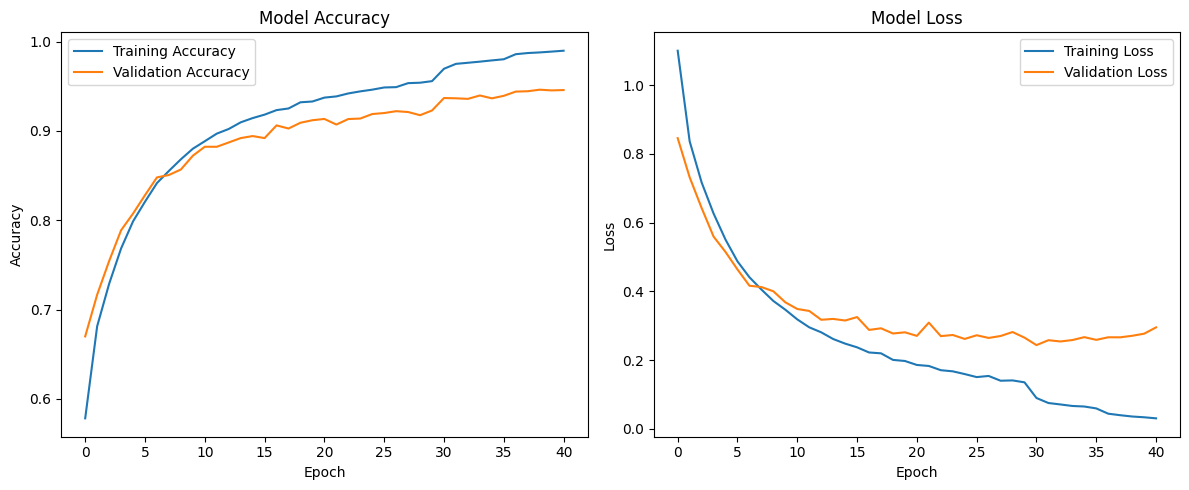

633/633 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Model Accuracy: 0.9368

Classification Report:
                 precision    recall  f1-score   support

 bad_back_round       0.94      0.93      0.94      2832
  bad_back_warp       0.90      0.93      0.92      3156
       bad_head       0.95      0.91      0.93      2757
bad_inner_thigh       0.93      0.94      0.93      2323
    bad_shallow       0.93      0.94      0.94      3206
        bad_toe       0.97      0.95      0.96      2997
           good       0.94      0.95      0.94      2966

       accuracy                           0.94     20237
      macro avg       0.94      0.94      0.94     20237
   weighted avg       0.94      0.94      0.94     20237



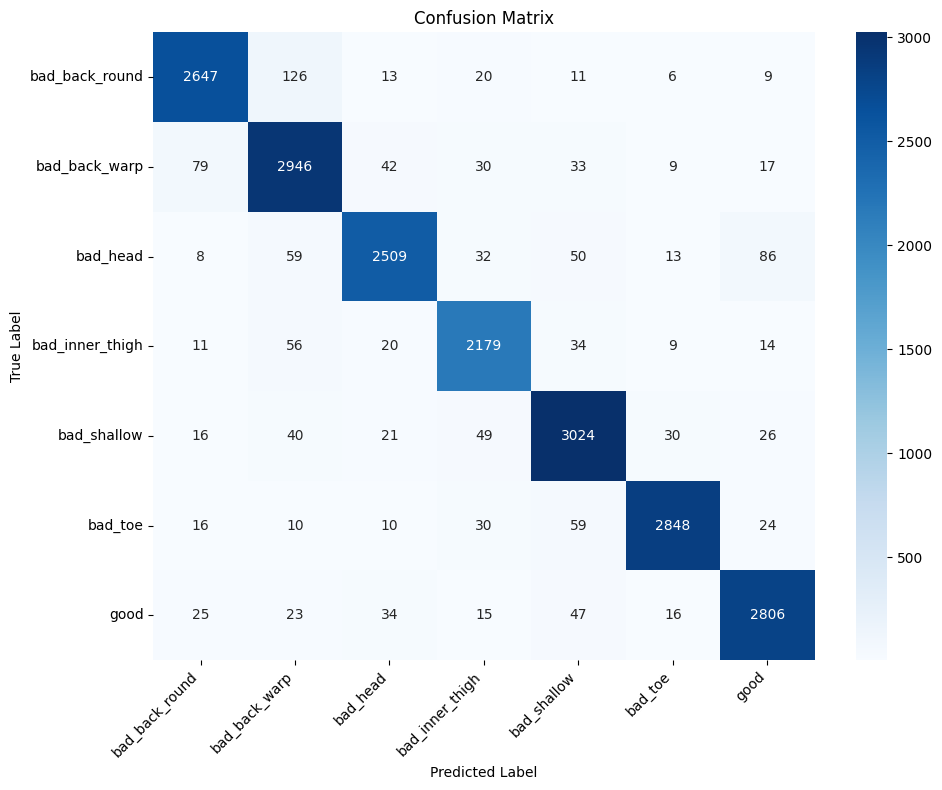

Training completed!


In [13]:
def main():
    """
    Main function to run the training pipeline
    """
    # Paths to preprocessed data
    X_path = "preprocessed_data_X.npy"
    y_path = "preprocessed_data_y_encoded.npy"
    scaler_path = "preprocessed_data_scaler.joblib"
    label_encoder_path = "preprocessed_data_label_encoder.joblib"
    
    # Load preprocessed data
    X_windows = np.load(X_path)
    y_encoded = np.load(y_path)
    label_encoder = joblib.load(label_encoder_path)
    
    # Prepare data for LSTM
    X_train, X_val, y_train, y_val, num_classes = prepare_data_for_lstm(X_windows, y_encoded)
    
    # Train model
    model, history = train_lstm_model(
        X_train, y_train, X_val, y_val, num_classes,
        model_path='best_squat_model.keras',
        epochs=100,
        batch_size=32,
        lstm_units=128,
        dropout_rate=0.5,
        bidirectional=True
    )
    
    # Plot training history
    plot_training_history(history)
    
    # Evaluate model
    evaluate_model(model, X_val, y_val, label_encoder)
    
    print("Training completed!")

if __name__ == "__main__":
    main()